In [1]:
# Accessing Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, make_scorer, fbeta_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from catboost import Pool, CatBoostClassifier, cv
#import lightgbm as lgb
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Get data
curdir = os.getcwd()
dataFolder = os.path.join(curdir, 'Data')

training_features = pd.read_csv(os.path.join(dataFolder, 'Training_set_values.csv'))
training_labels = pd.read_csv(os.path.join(dataFolder, 'Training_set_labels.csv'))
test_features = pd.read_csv(os.path.join(dataFolder, 'Test_set_values.csv'))

In [3]:
# Merge training and test data
training_data = pd.merge(training_features, training_labels, on='id')
data = pd.concat([training_data, test_features], ignore_index=True)
display(data.head())

,amount_tsh,basin,construction_year,date_recorded,district_code,extraction_type,extraction_type_class,extraction_type_group,funder,gps_height,...,source,source_class,source_type,status_group,subvillage,ward,water_quality,waterpoint_type,waterpoint_type_group,wpt_name
0,6000.0,Lake Nyasa,1999,2011-03-14,5,gravity,gravity,gravity,Roman,1390,...,spring,groundwater,spring,functional,Mnyusi B,Mundindi,soft,communal standpipe,communal standpipe,none
1,0.0,Lake Victoria,2010,2013-03-06,2,gravity,gravity,gravity,Grumeti,1399,...,rainwater harvesting,surface,rainwater harvesting,functional,Nyamara,Natta,soft,communal standpipe,communal standpipe,Zahanati
2,25.0,Pangani,2009,2013-02-25,4,gravity,gravity,gravity,Lottery Club,686,...,dam,surface,dam,functional,Majengo,Ngorika,soft,communal standpipe multiple,communal standpipe,Kwa Mahundi
3,0.0,Ruvuma / Southern Coast,1986,2013-01-28,63,submersible,submersible,submersible,Unicef,263,...,machine dbh,groundwater,borehole,non functional,Mahakamani,Nanyumbu,soft,communal standpipe multiple,communal standpipe,Zahanati Ya Nanyumbu
4,0.0,Lake Victoria,0,2011-07-13,1,gravity,gravity,gravity,Action In A,0,...,rainwater harvesting,surface,rainwater harvesting,functional,Kyanyamisa,Nyakasimbi,soft,communal standpipe,communal standpipe,Shuleni


In [4]:
# Overall data info
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 41 columns):
amount_tsh               74250 non-null float64
basin                    74250 non-null object
construction_year        74250 non-null int64
date_recorded            74250 non-null object
district_code            74250 non-null int64
extraction_type          74250 non-null object
extraction_type_class    74250 non-null object
extraction_type_group    74250 non-null object
funder                   69746 non-null object
gps_height               74250 non-null int64
id                       74250 non-null int64
installer                69718 non-null object
latitude                 74250 non-null float64
lga                      74250 non-null object
longitude                74250 non-null float64
management               74250 non-null object
management_group         74250 non-null object
num_private              74250 non-null int64
payment                  74250 non-null object


None

In [5]:
# Show how many columns are null
data.isnull().sum()

amount_tsh                   0
basin                        0
construction_year            0
date_recorded                0
district_code                0
extraction_type              0
extraction_type_class        0
extraction_type_group        0
funder                    4504
gps_height                   0
id                           0
installer                 4532
latitude                     0
lga                          0
longitude                    0
management                   0
management_group             0
num_private                  0
payment                      0
payment_type                 0
permit                    3793
population                   0
public_meeting            4155
quality_group                0
quantity                     0
quantity_group               0
recorded_by                  0
region                       0
region_code                  0
scheme_management         4846
scheme_name              35258
source                       0
source_c

In [6]:
# fill null items with 'nan' for test and training data
data.fillna('nan', inplace=True)

In [7]:
data.isnull().sum()

amount_tsh               0
basin                    0
construction_year        0
date_recorded            0
district_code            0
extraction_type          0
extraction_type_class    0
extraction_type_group    0
funder                   0
gps_height               0
id                       0
installer                0
latitude                 0
lga                      0
longitude                0
management               0
management_group         0
num_private              0
payment                  0
payment_type             0
permit                   0
population               0
public_meeting           0
quality_group            0
quantity                 0
quantity_group           0
recorded_by              0
region                   0
region_code              0
scheme_management        0
scheme_name              0
source                   0
source_class             0
source_type              0
status_group             0
subvillage               0
ward                     0
w

In [8]:
# Setting the chosen features from the training data
chosen_features = []

Class functional is 54.3081% of the dataset
Class functional needs repair is 7.2677% of the dataset
Class non functional is 38.4242% of the dataset


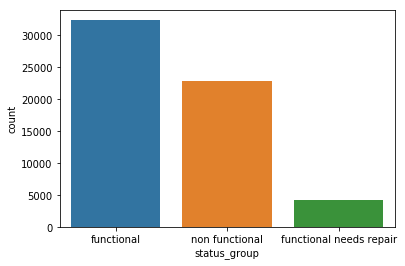

In [9]:
# Checking the status_group column
sns.countplot(x = 'status_group', data = training_labels)
series = pd.Categorical(training_labels.status_group)
keys = series.categories
total = series.size
for key in keys:
    count = training_labels[training_labels.status_group == key].count()
    print('Class', key, 'is {:.4f}% of the dataset'.format(count[0]/total*100))
#print()

This is a skewed training set with unequal distribution of each class. Therefore Accuracy isn't the best metric to classifiy the data. Precision is required as false positives can lead to unwanted scenarios, where repair would be delayed or not possible at all. I would be using fbeta score ([source](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html)), with beta=0.5

In [11]:
# bar plot function
#def barPlot(df, columnStr):
#    cross_tab = pd.crosstab(index=df[columnStr], columns=df["status_group"])
#    cross_tab.plot(kind='bar', stacked = True)


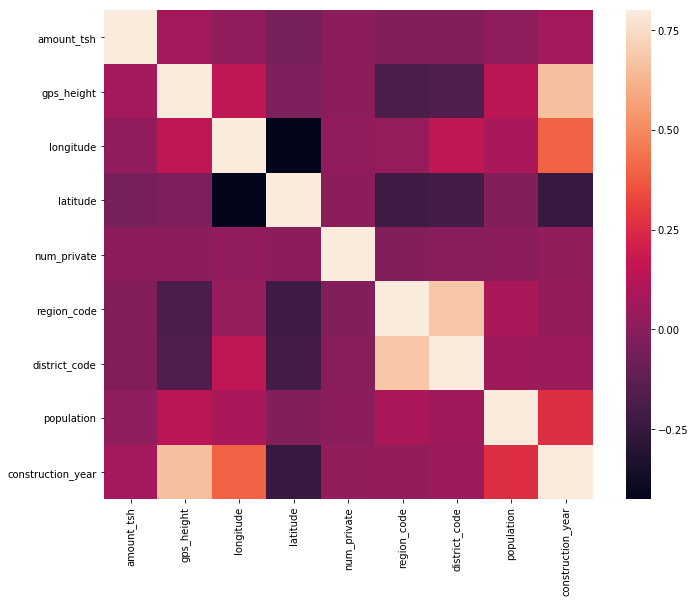

In [12]:
# correlation matrix
x_train = training_data.drop(columns=['id'])
corr_mat = x_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_mat, vmax=.8, square=True);

The correlated columns include gps_height, longitude, latitude, region_code, district_code, population and construction_year

In fact, region_code and district_code form a situation of multi-colinearity.

In [13]:
# Let's Look at Location based features - longitude and latitude
display(data['longitude'].describe())
display(data['latitude'].describe())

count    74250.000000
mean        34.074262
std          6.572519
min          0.000000
25%         33.086819
50%         34.907475
75%         37.181685
max         40.345193
Name: longitude, dtype: float64

count    7.425000e+04
mean    -5.701771e+00
std      2.944969e+00
min     -1.164944e+01
25%     -8.525675e+00
50%     -5.026540e+00
75%     -3.325058e+00
max     -2.000000e-08
Name: latitude, dtype: float64

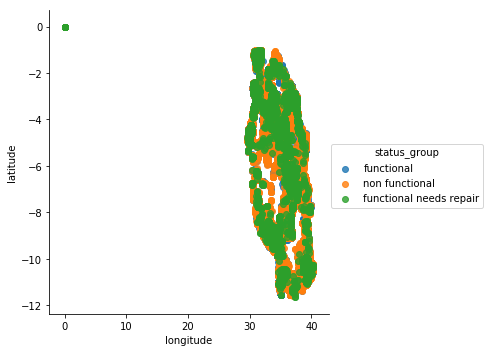

In [14]:
# Plotting longitude and latitude
#plt.scatter(data.longitude, data.latitude, hue=)
df = data[data.status_group != 'nan']
sns.lmplot(x = 'longitude', y = 'latitude', data = df, hue = 'status_group', fit_reg= False)

The data has a 0 value which doesn't make sense.

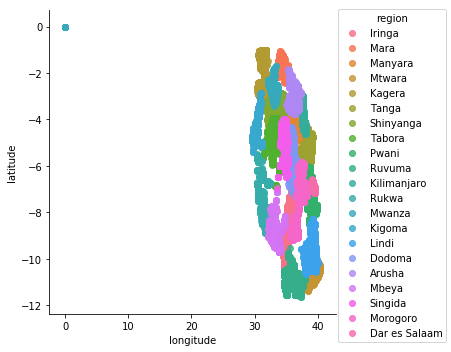

In [15]:
# Looking at other Location based values such as region code and district code
sns.lmplot(x = 'longitude', y = 'latitude', data = df, hue = 'region', fit_reg= False)

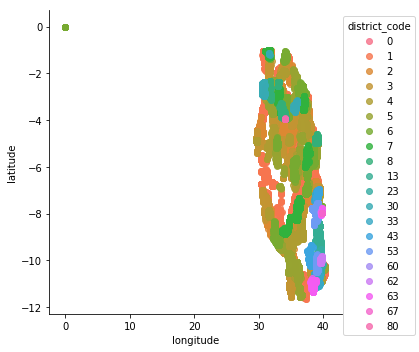

In [16]:
sns.lmplot(x = 'longitude', y = 'latitude', data = df, hue = 'district_code', fit_reg= False)

The region or region_code seem to be a higher level of location based feature. District codes are within the specified regions.

In [17]:
crosstab_region = pd.crosstab([df.region_code, df.region], df.status_group)
display(crosstab_region)
#Gp_region = df.groupby(by=['region_code'])
#Gp_region.region.value_counts()

status_group               functional  functional needs repair  non functional
region_code region                                                            
1           Dodoma               1009                      209             983
2           Arusha               1978                      174             872
3           Kilimanjaro          2640                      322            1417
4           Tanga                1408                       73            1032
5           Morogoro             2119                      300            1587
            Tanga                  28                        0               6
6           Pwani                1066                       16             527
7           Dar es Salaam         461                        3             341
8           Lindi                  26                       15             259
9           Mtwara                139                       21             230
10          Ruvuma               1480                      164             996
11          Iringa               4141                      123            1030
            Shinyanga               2                        0               4
12          Mbeya                2319                      504            1816
13          Singida              1011                      128             954
14          Shinyanga              14                        2               4
            Tabora                848                       45            1066
15          Rukwa                 707                      135             966
16          Kigoma               1363                      603             850
17          Mwanza                 34                        5              16
            Shinyanga            2773                      633            1550
18          Kagera               1727                      304            1285
            Lindi                   2                        0               6
19          Mwanza               1468                      178            1401
20          Mara                  886                       60            1023
21          Manyara               987                       96             500
24          Arusha                316                        1               9
40          Pwani                   0                        0               1
60          Pwani                 490                       20             515
80          Lindi                 432                       78             728
90          Mtwara                194                       98             625
99          Mtwara                191                        7             225

In [18]:
crosstab_region_district = pd.crosstab([df.region_code, df.district_code], df.status_group)
display(crosstab_region_district)

status_group               functional  functional needs repair  non functional
region_code district_code                                                     
1           0                       4                        2              17
            1                     412                      142             334
            3                     203                        0             158
            4                     144                       29             174
            5                      88                       36             234
            6                     158                        0              66
2           1                      95                       30              64
            2                     839                       46             321
            3                      78                        9              22
            5                     109                       28              64
            6                     200                       29              81
            7                     657                       32             320
3           1                     209                       14             372
            2                     231                       49             239
            3                     449                      131             297
            4                     721                      122             382
            5                     540                        4              76
            6                      78                        0              31
            7                     412                        2              20
4           1                     434                       59             205
            2                     240                        6             162
            3                     216                        0             107
            4                      45                        3              62
            5                      65                        3             225
            6                     139                        1             126
            7                      45                        1              81
            8                     224                        0              64
5           1                     615                       73             440
            2                     252                       52             217
            3                     525                       83             389
...                               ...                      ...             ...
19          5                     174                        0             158
            6                     266                       17             205
            7                     180                        0             167
            8                      52                        8              72
20          1                     115                        0              56
            2                     424                       27             265
            3                     149                       26             221
            4                     133                        6             299
            6                      65                        1             182
21          1                     406                       58              86
            2                     191                        0              83
            3                     191                       10              96
            4                     158                        2             116
            5                      41                       26             119
24          30                    316                        1               9
40          43                      0                        0               1
60          33                     42                        0              73
            43                    174             

To impute the GPS data I choose to create a groupby dataframe based on region_code and district_code. The zero instances of both columns 
are then given the median of the groupby dataframe (either using region and district_code togther or just from region). The median of the data is a good way for center measure considering that the data contains zeros. 

In [19]:
# creating a function for the imputed Longitude and Latitude data
df_region_DC = data.groupby(['region_code','district_code'])
df_region = data.groupby('region_code')
def LocationImputedSeries(df, df_region_DC, df_region):
    Long_med_reg_DC = df_region_DC.longitude.median()
    Lat_med_reg_DC = df_region_DC.latitude.median()
    Long_med_reg = df_region.longitude.median()
    Lat_med_reg = df_region.latitude.median()
    # Zero indices
    long_index = df.longitude.loc[np.absolute(df.longitude) < 0.001].keys().tolist()
    lat_index = df.latitude.loc[np.absolute(df.latitude) < 0.001].keys().tolist()
    long_data = df.longitude.tolist()
    lat_data = df.latitude.tolist()
    # Longitude:
    for i in long_index:
        if abs(long_data[i]) < 0.001:
            reg = df.region_code.loc[i]
            dist = df.district_code.loc[i]
            long_data[i] = Long_med_reg_DC[(reg, dist)]  # Taking the median using the groupby of region and distric code
            if abs(long_data[i]) < 0.001:
                long_data[i] = Long_med_reg[reg]   # Taking the median of only the region groupby, in case the previous value=0
    # Latitude:
    for i in lat_index:
        if abs(lat_data[i]) < 0.001:
            reg = df.region_code.loc[i]
            dist = df.district_code.loc[i]
            lat_data[i] = Lat_med_reg_DC[(reg, dist)]
            if abs(lat_data[i]) < 0.001:
                lat_data[i] = Lat_med_reg[reg]
    return (long_data, lat_data)

In [20]:
Long_data , Lat_data = LocationImputedSeries(data, df_region_DC, df_region)
data['Longitude_new'] = pd.Series(Long_data, index=data.index)
data['Latitude_new'] = pd.Series(Lat_data, index=data.index)

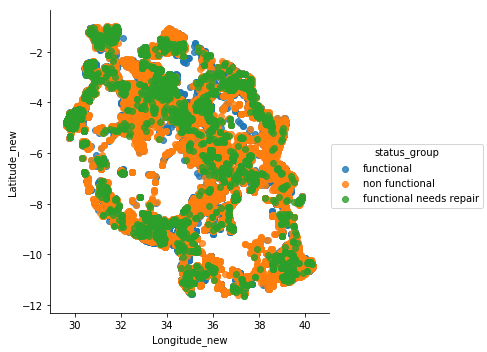

In [21]:
# scatter plot of new imputed data
df = data[data.status_group != 'nan']
sns.lmplot(x='Longitude_new', y='Latitude_new', hue='status_group', data = df, fit_reg=False)

In [22]:
#choosing both latitude and longitude
if 'Latitude_new' not in chosen_features:
    chosen_features.append('Latitude_new')
if 'Longitude_new' not in chosen_features:
    chosen_features.append('Longitude_new')
if 'region_code' not in chosen_features:
    chosen_features.append('region_code')
if 'district_code' not in chosen_features:
    chosen_features.append('district_code')

In [23]:
# Taking a look at the last Location based feature- 'subvillage'
display(training_data['subvillage'].describe())

count        59029
unique       19287
top       Madukani
freq           508
Name: subvillage, dtype: object

Categorical feature of almost 20000 unique features. This would need some Feature engineering too.
The Idea is to save the frequency of each category as a separate feature.

In [24]:
def freq_map(x):
    try:
        return freq[x]
    except KeyError:
        return 0
df = data[data.status_group!='nan']  # only on the training data
freq = df['subvillage'].value_counts().to_dict()
data['subvillage_freq'] = data['subvillage'].apply(freq_map)
display(data['subvillage'].describe())
display(data['subvillage_freq'].describe())

count       74250
unique      21426
top       Shuleni
freq          646
Name: subvillage, dtype: object

count    74250.000000
mean        33.955394
std         93.287365
min          0.000000
25%          2.000000
50%          5.000000
75%         13.000000
max        508.000000
Name: subvillage_freq, dtype: float64

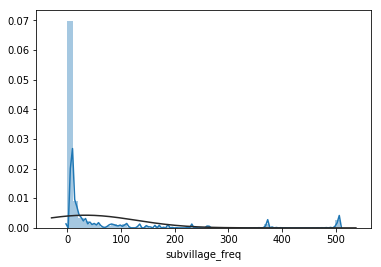

In [25]:
# Making histogram of the frequency table
from scipy.stats import norm
sns.distplot(data['subvillage_freq'], hist=True, fit=norm)

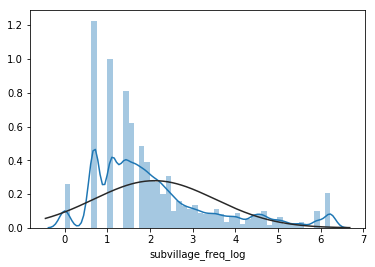

In [26]:
# Taking Log of the above data to make it normal
data['subvillage_freq_log'] = data['subvillage_freq'].apply(lambda x: np.log(x+1))
sns.distplot(data['subvillage_freq_log'], hist = True, fit=norm)

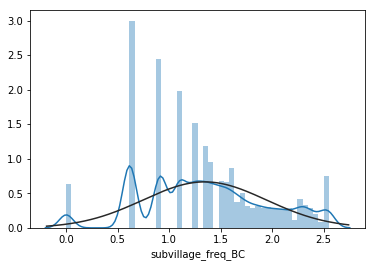

In [27]:
# Let's also do a Box-Cox transformation
from scipy.stats import boxcox
data['subvillage_freq_BC'] = boxcox(data['subvillage_freq'] + 1)[0]
sns.distplot(data['subvillage_freq_BC'], hist = True, fit=norm)

Clearly, the Box-Cox transformation looks better than a simple logarithmic transformation

count    59400.000000
mean       668.297239
std        693.116350
min        -90.000000
25%          0.000000
50%        369.000000
75%       1319.250000
max       2770.000000
Name: gps_height, dtype: float64


Text(0.5,1,'gps_height distribution via location data')

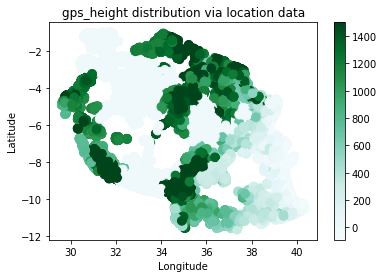

In [28]:
# Now looking at the gps_height feature
df = data[data.status_group != 'nan']
print(df['gps_height'].describe())
points = plt.scatter(df['Longitude_new'], df['Latitude_new'], c=df['gps_height'], s=75, cmap="BuGn", 
                     vmin=np.min(df['gps_height']), vmax=1500)
plt.colorbar(points)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('gps_height distribution via location data')

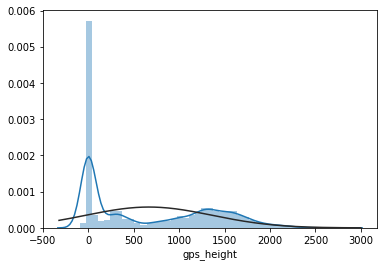

In [29]:
# Lets plot the histogram of this variable
df = data[data.status_group != 'nan']
sns.distplot(df['gps_height'], hist = True, fit=norm)

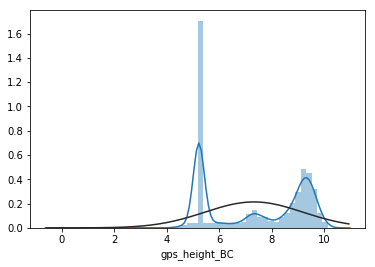

In [30]:
# Transform this using Box Cox tranformation
df = data[data.status_group != 'nan'] # Using only training data
min_datapoint = np.min(df['gps_height'])
C = 1 - min_datapoint # Making the data positive
data['gps_height_BC'] = boxcox(data['gps_height'] + C)[0]
sns.distplot(data['gps_height_BC'], hist = True, fit=norm)

In [31]:
#choosing both latitude and longitude
if 'Latitude_new' not in chosen_features:
    chosen_features.append('Latitude_new')
if 'Longitude_new' not in chosen_features:
    chosen_features.append('Longitude_new')
if 'region_code' not in chosen_features:
    chosen_features.append('region_code')
if 'district_code' not in chosen_features:
    chosen_features.append('district_code')

In [32]:
# choosing Box-Cox transformed gps_height and frequency column of subvillage
if 'subvillage_freq_BC' not in chosen_features:
    chosen_features.append('subvillage_freq_BC')
if 'gps_height_BC' not in chosen_features:
    chosen_features.append('gps_height_BC')

gps_height and construction_year had a bit of correlation. Let's check that out!

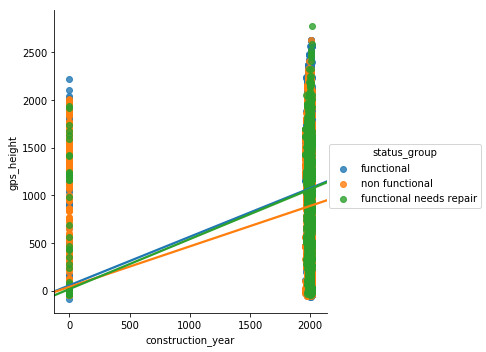

In [33]:
# scatter plot of gps_height and construction year
df=data[data.status_group!='nan']
sns.lmplot(x='construction_year', y='gps_height', hue='status_group', data = df, fit_reg=True)

construction year of 0 doesn't make sense. Maybe the construction year before a certain time wasn't recorded!

In [36]:
df = data[data.status_group!='nan']
rows = df.shape[0]
nonzero_data = df[df.construction_year > 0]
nonzero_rows = nonzero_data.shape[0]
print('there are {0:.3f}% non-zero entries out of {1:d} total entries in this feature'.format(nonzero_rows/rows*100, rows))

there are 65.136% non-zero entries out of 59400 total entries in this feature


In [37]:
# For the test set
df = data[data.status_group =='nan']
rows = df.shape[0]
nonzero_data = df[df.construction_year > 0]
nonzero_rows = nonzero_data.shape[0]
print('there are {0:.3f}% non-zero entries out of {1:d} total entries in this feature'.format(nonzero_rows/rows*100, rows))

there are 64.579% non-zero entries out of 14850 total entries in this feature


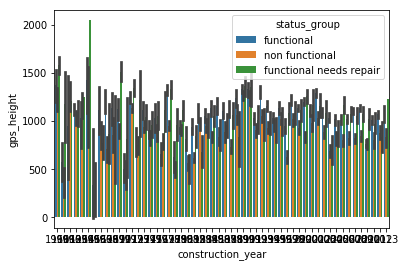

In [36]:
df =data[data.status_group!='nan']
#print(df['construction_year'].value_counts())
#print('The number of values in construction_year that are 0: {:.4f}'.format(np.sum(df['construction_year']>0)))
df = df[df['construction_year'] > 0]
#plt.figure()
sns.barplot(x='construction_year', y='gps_height', hue='status_group', data=df)
#sns.lmplot(x='construction_year', y='gps_height', hue='status_group', data = df, fit_reg=True)

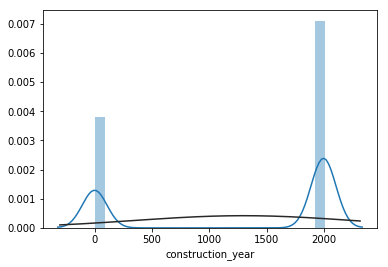

In [40]:
sns.distplot(data['construction_year'], hist=True, fit=norm)

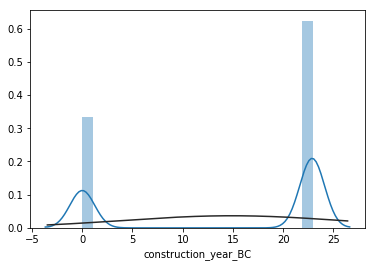

In [42]:
# making BoxCox transformation
data['construction_year_BC'] = boxcox(data['construction_year'] + 1)[0]
sns.distplot(data['construction_year_BC'], hist=True, fit=norm)

In [44]:
# Also create feature of construction year == 0
def func(x):
    if x > 0:
        return 0
    else:
        return 1
data['construction_year_missing'] = data['construction_year'].apply(lambda x: func(x))
display(data['construction_year_missing'].describe())

count    74250.000000
mean         0.349751
std          0.476894
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: construction_year_missing, dtype: float64

In [45]:
if 'construction_year_missing' not in chosen_features:
    chosen_features.append('construction_year_missing')
if 'construction_year_BC' not in chosen_features:
    chosen_features.append('construction_year_BC')

In [46]:
# Funder feature
#barPlot(data, "funder")
display(data['funder'].describe())

count                      74250
unique                      2141
top       Government Of Tanzania
freq                       11299
Name: funder, dtype: object

With another feature with numerous instances, let's take its frequency as a feature and transform it a bit, for it to behave somewhat closer to a normal distribution.

In [47]:
def freq_map(x):
    try:
        return freq[x]
    except KeyError:
        return 0
df = data[data.status_group!='nan']  # only on the training data
freq = df['funder'].value_counts().to_dict()
#print(freq)
data['funder_freq'] = data['funder'].apply(freq_map)
print(data['funder'].describe())
print(data['funder_freq'].describe())

count                      74250
unique                      2141
top       Government Of Tanzania
freq                       11299
Name: funder, dtype: object
count    74250.000000
mean      2157.777899
std       3109.394153
min          0.000000
25%        125.000000
50%        765.000000
75%       3114.000000
max       9084.000000
Name: funder_freq, dtype: float64


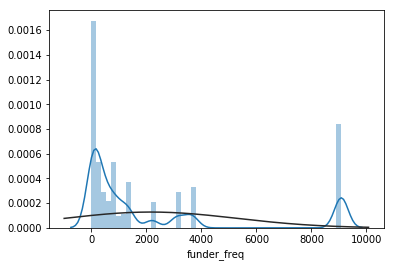

In [48]:
# Making histogram of the frequency table
#from scipy.stats import norm
sns.distplot(data['funder_freq'], hist=True, fit=norm)

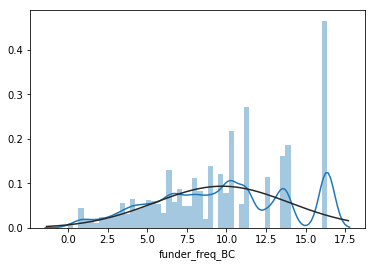

In [49]:
data['funder_freq_BC'] = boxcox(data['funder_freq'] + 1)[0]
sns.distplot(data['funder_freq_BC'], hist = True, fit=norm)

In [50]:
# Adding funder_freq_BC in the list of features
if 'funder_freq_BC' not in chosen_features:
    chosen_features.append('funder_freq_BC')

In [51]:
# Doing a similar kind of feature engineering for installer column
def freq_map(x):
    try:
        return freq[x]
    except KeyError:
        return 0
df = data[data.status_group!='nan']  # only on the training data
freq = df['installer'].value_counts().to_dict()
#print(freq)
data['installer_freq'] = data['installer'].apply(freq_map)
display(data['installer'].describe())
display(data['installer_freq'].describe())

count     74250
unique     2411
top         DWE
freq      21751
Name: installer, dtype: object

count    74250.000000
mean      5573.760000
std       7661.699018
min          0.000000
25%        119.000000
50%        622.000000
75%      17402.000000
max      17402.000000
Name: installer_freq, dtype: float64

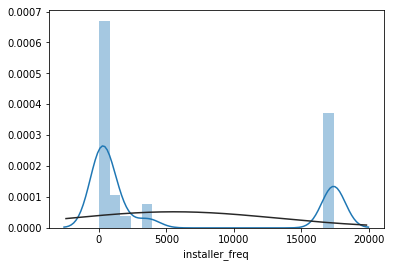

In [52]:
# Making histogram of the frequency table
#from scipy.stats import norm
sns.distplot(data['installer_freq'], hist=True, fit=norm)

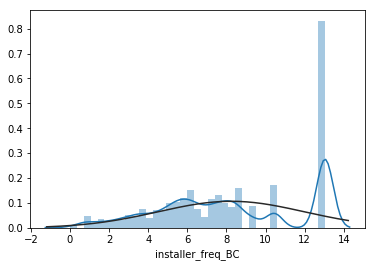

In [53]:
data['installer_freq_BC'] = boxcox(data['installer_freq'] + 1)[0]
sns.distplot(data['installer_freq_BC'], hist = True, fit=norm)

In [54]:
#adding installer_3
if 'installer_freq_BC' not in chosen_features:
    chosen_features.append('installer_freq_BC')

In [55]:
# Checking wpt_name
data.wpt_name.describe()

count     74250
unique    45684
top        none
freq       4440
Name: wpt_name, dtype: object

This feature has more than half of the number of instances as unique. This might cause trouble in grouping or making decision trees. And I'm not sure what it exactly represents. Therefore, I'm going to keep this one out.

count    74250.000000
mean         0.462330
std         11.537879
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       1776.000000
Name: num_private, dtype: float64

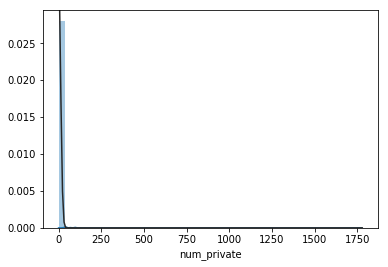

In [56]:
# We now go through num_private
# The data seems heavily centered at 0, with about 200 points greater than that
display(data['num_private'].describe())
sns.distplot(data['num_private'], hist=True, fit=norm)

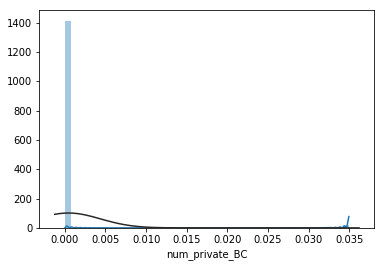

In [57]:
# Taking Box Cox Transformation 
data['num_private_BC'] = boxcox(data['num_private'] + 1)[0]
sns.distplot(data['num_private_BC'], hist=True, fit=norm)

In [58]:
if 'num_private_BC' not in chosen_features:
    chosen_features.append('num_private_BC')

count             74250
unique                9
top       Lake Victoria
freq              12871
Name: basin, dtype: object

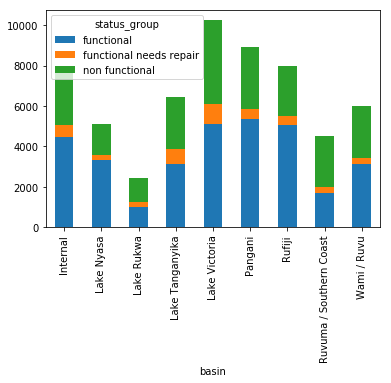

In [59]:
#Now exploring basin
display(data['basin'].describe())
#pd.Categorical(data.basin)
df = data[data.status_group!='nan']
barPlot(df, 'basin')

In [60]:
if 'basin' not in chosen_features:
    chosen_features.append('basin')

In [61]:
display(data.ward.describe())

count     74250
unique     2098
top       Igosi
freq        386
Name: ward, dtype: object

In [62]:
# Taking the frequency of the instances in a separate column and transforming it to normal distribution
def freq_map(x):
    try:
        return freq[x]
    except KeyError:
        return 0
df = data[data.status_group!='nan']  # only on the training data
freq = df['ward'].value_counts().to_dict()
#print(freq)
data['ward_freq'] = data['ward'].apply(freq_map)
display(data['ward'].describe())
display(data['ward_freq'].describe())

count     74250
unique     2098
top       Igosi
freq        386
Name: ward, dtype: object
count    74250.000000
mean        56.197024
std         48.461472
min          0.000000
25%         25.000000
50%         42.000000
75%         70.000000
max        307.000000
Name: ward_freq, dtype: float64


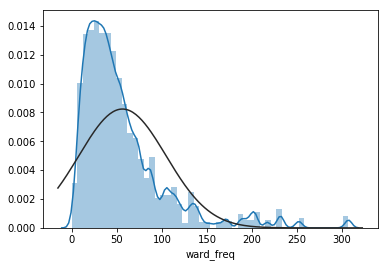

In [63]:
sns.distplot(data['ward_freq'], hist=True, fit=norm)

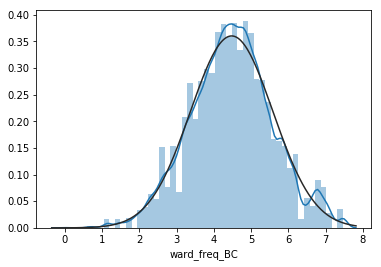

In [64]:
data['ward_freq_BC'] = boxcox(data['ward_freq'] + 1)[0]
sns.distplot(data['ward_freq_BC'], hist=True, fit=norm)

In [65]:
if 'ward_freq_BC' not in chosen_features:
    chosen_features.append('ward_freq_BC')

In [66]:
# exploring lga
display(data.lga.describe())

count      74250
unique       125
top       Njombe
freq        3128
Name: lga, dtype: object

In [67]:
# Taking the frequency of the instances in a separate column and transforming it to normal distribution
def freq_map(x):
    try:
        return freq[x]
    except KeyError:
        return 0
df = data[data.status_group!='nan']  # only on the training data
freq = df['lga'].value_counts().to_dict()
#print(freq)
data['lga_freq'] = data['lga'].apply(freq_map)
print(data['lga'].describe())
print(data['lga_freq'].describe())

count      74250
unique       125
top       Njombe
freq        3128
Name: lga, dtype: object
count    74250.000000
mean       714.775704
std        477.140190
min          1.000000
25%        399.000000
50%        626.000000
75%        877.000000
max       2503.000000
Name: lga_freq, dtype: float64


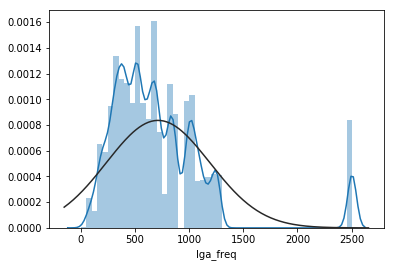

In [68]:
sns.distplot(data['lga_freq'], hist=True, fit=norm)

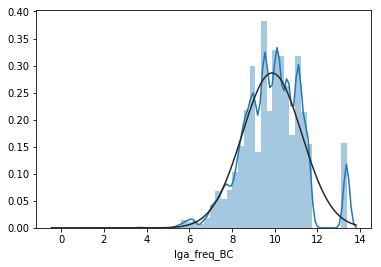

In [69]:
data['lga_freq_BC'] = boxcox(data['lga_freq'])[0]
sns.distplot(data['lga_freq_BC'], hist=True, fit=norm)

In [70]:
if 'lga_freq_BC' not in chosen_features:
    chosen_features.append('lga_freq_BC')

In [71]:
# Let's look at the population around the well
display(data['population'].describe())

count    74250.000000
mean       180.750828
std        471.086120
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

Statistical measures for Population feature, mean: 179.9100 stdev: 471.4822


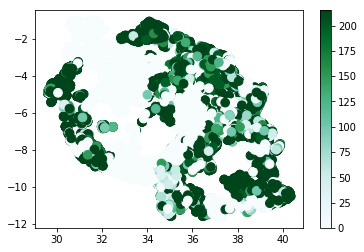

In [72]:
# Plot population with respect to GPS locations
df = data[data.status_group != 'nan']
#print(df['population'].describe())
mean_pop = df['population'].mean()
std_pop = df['population'].std()
print('Statistical measures for Population feature, mean: {0:.4f} stdev: {1:.4f}'.format(mean_pop, std_pop))
points = plt.scatter(df['Longitude_new'], df['Latitude_new'], c=df['population'], s=75, cmap="BuGn", 
                     vmin=0, vmax=215)
plt.colorbar(points)

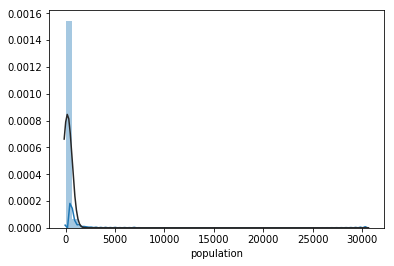

In [73]:
sns.distplot(data['population'], hist=True, fit=norm)

This data is heavily influenced by the highest frequency of 0. Although it doesn't sound like an anomaly as there could be 0 population in certain areas and the GPS plot doesn't show any weirdness in the numbers 

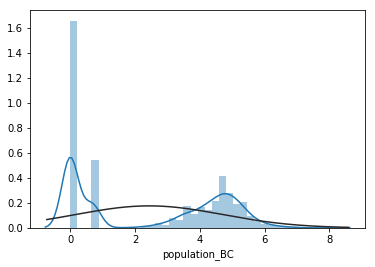

In [74]:
# Transforming via BoxCox
data['population_BC'] = boxcox(data['population'] + 1)[0]
sns.distplot(data['population_BC'], hist=True, fit=norm)

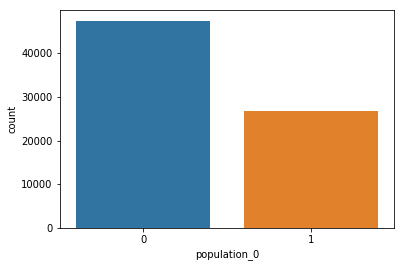

In [75]:
def func_pop(x):
    if x > 0:
        return 0
    else:
        return 1
data['population_0'] = data['population'].apply(func_pop)
sns.countplot(data=data, x='population_0')

In [76]:
if 'population_0' not in chosen_features:
    chosen_features.append('population_0')
if 'population_BC' not in chosen_features:
    chosen_features.append('population_BC')

In [77]:
# Feature - Public Meeting
display(data['public_meeting'].describe())

count     74250
unique        3
top        True
freq      63749
Name: public_meeting, dtype: object

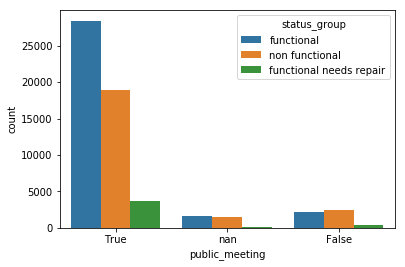

In [79]:
df = data[data.status_group!='nan']
sns.countplot(x='public_meeting', data=df, hue='status_group')

Not sure if this feature would help the classifier, but I'll put it in anyway for now. 

In [80]:
if 'public_meeting' not in chosen_features:
    chosen_features.append('public_meeting')

In [81]:
display(df['recorded_by'].describe())

count                       59400
unique                          1
top       GeoData Consultants Ltd
freq                        59400
Name: recorded_by, dtype: object

This feature has only one value. So not including this in the list

In [82]:
# checking the scheme data
display(df['scheme_management'].describe())
display(df['scheme_name'].describe())
display(df['permit'].describe())

count     59400
unique       13
top         VWC
freq      36793
Name: scheme_management, dtype: object

count     59400
unique     2697
top         nan
freq      28166
Name: scheme_name, dtype: object

count     59400
unique        3
top        True
freq      38852
Name: permit, dtype: object

In [83]:
# Grouping scheme_management
cross_tab_SM = pd.crosstab([df.scheme_management, df.permit], df.status_group)
display(cross_tab_SM)

status_group              functional  functional needs repair  non functional
scheme_management permit                                                     
Company           False            9                        1               8
                  True           503                       34             479
                  nan             22                        2               3
None              False            1                        0               0
Other             False           43                        2              29
                  True           309                       14             219
                  nan            106                        6              38
Parastatal        False          343                       92             198
                  True           505                       94             278
                  nan            118                       16              36
Private operator  False          462                       14             236
                  True           249                        9              74
                  nan             18                        0               1
SWC               False           20                        1              76
Trust             False           16                        1              10
                  True            29                        4              11
                  nan              1                        0               0
VWC               False         5503                      637            5051
                  True         12330                     1454            9685
                  nan           1127                      243             763
WUA               False          308                       42             130
                  True          1657                      189             492
                  nan             30                        8              27
WUG               False         1705                      447             869
                  True          1236                      217             575
                  nan             65                        8              84
Water Board       False           75                       20              67
                  True          1912                       83             493
                  nan             66                        8              24
Water authority   False          320                       44             241
                  True          1199                      397             757
                  nan             99                        7              89
nan               False          240                       19             212
                  True          1612                      202            1551
                  nan             21                        2              18

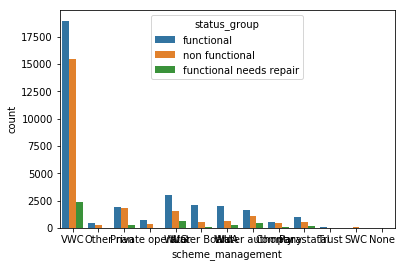

In [84]:
sns.countplot(data=df, x='scheme_management', hue='status_group')

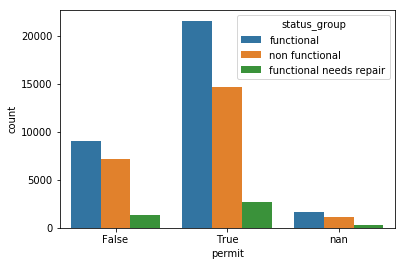

In [85]:
sns.countplot(data=df, x='permit', hue='status_group')

In [86]:
# scheme_name would need some feature engineering
scheme_name_str = data.scheme_name.astype('str')
scheme_name = [s[:3].lower() for s in scheme_name_str]
scheme_name_series = pd.Categorical(scheme_name)
data['scheme_name_3'] = scheme_name_series
print(data['scheme_name_3'].describe())

count     74250
unique      856
top         nan
freq      35323
Name: scheme_name_3, dtype: object


Almost half the data here is missing. So not including this feature

In [87]:
if 'scheme_management' not in chosen_features:
    chosen_features.append('scheme_management')
if 'permit' not in chosen_features:
    chosen_features.append('permit')

In [88]:
# Looking at other management related features - management, management_group
df = data[data.status_group!='nan']
print(df.management.describe())
print()
print(df.management_group.describe())

count     59400
unique       12
top         vwc
freq      40507
Name: management, dtype: object

count          59400
unique             5
top       user-group
freq           52490
Name: management_group, dtype: object


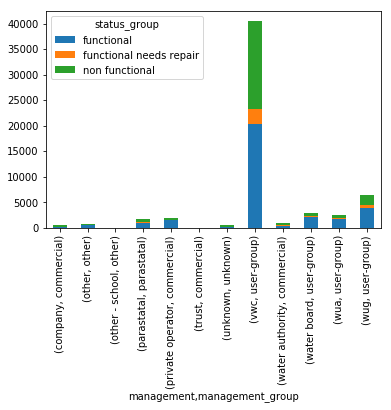

In [89]:
crosstab_management = pd.crosstab([df.management, df.management_group], df.status_group)
crosstab_management.plot(kind='bar', stacked = True)

In [90]:
# including these columns too
if 'management' not in chosen_features:
    chosen_features.append('management')
if 'management_group' not in chosen_features:
    chosen_features.append('management_group')

In [91]:
#checking the extraction features - extraction_type, extraction_type_group, extraction_type_class
df = data[data.status_group!='nan']
print(df['extraction_type'].describe())
print()
print(df['extraction_type_class'].describe())
print()
print(df['extraction_type_group'].describe())

count       59400
unique         18
top       gravity
freq        26780
Name: extraction_type, dtype: object

count       59400
unique          7
top       gravity
freq        26780
Name: extraction_type_class, dtype: object

count       59400
unique         13
top       gravity
freq        26780
Name: extraction_type_group, dtype: object


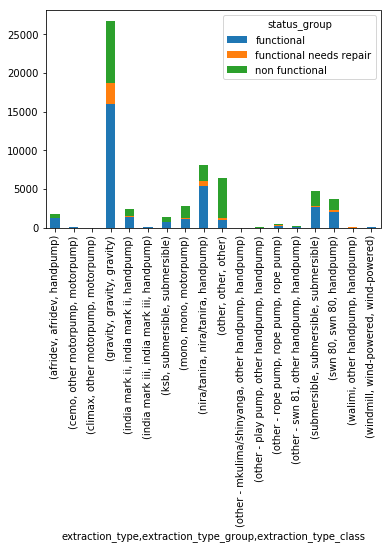

In [92]:
cross_tab_extraction = pd.crosstab([df.extraction_type, df.extraction_type_group, df.extraction_type_class], df.status_group)
cross_tab_extraction.plot(kind='bar', stacked=True)

The extraction_type_group seems to mimic extraction_type feature. Therefore included the extraction_type and extraction_type_class.

In [93]:
if 'extraction_type' not in chosen_features:
    chosen_features.append('extraction_type')
if 'extraction_type_class' not in chosen_features:
    chosen_features.append('extraction_type_class')

In [94]:
# checking features related to payment- payment, payment_type
display(df.payment.describe())
display(df.payment_type.describe())

count         59400
unique            7
top       never pay
freq          25348
Name: payment, dtype: object

count         59400
unique            7
top       never pay
freq          25348
Name: payment_type, dtype: object

In [95]:
cross_tab_payment = pd.crosstab([df.payment, df.payment_type], df.status_group)
display(cross_tab_payment)

,status_group,functional,functional needs repair,non functional
payment,payment_type,,,
never pay,never pay,11379,1907,12062
other,other,611,118,325
pay annually,annually,2740,247,655
pay monthly,monthly,5482,927,1891
pay per bucket,per bucket,6090,409,2486
pay when scheme fails,on failure,2429,277,1208
unknown,unknown,3528,432,4197


In [96]:
# Since both the features represent the same thing, I shall add payment_type as the features are more compact
if 'payment_type' not in chosen_features:
    chosen_features.append('payment_type')

In [97]:
# taking the water quality into consideration- water_quality, quality_group
display(df.water_quality.describe())
#print()
display(df.quality_group.describe())

count     59400
unique        8
top        soft
freq      50818
Name: water_quality, dtype: object

count     59400
unique        6
top        good
freq      50818
Name: quality_group, dtype: object

In [98]:
crosstab_quality = pd.crosstab([df.water_quality, df.quality_group], df.status_group)
display(crosstab_quality)

,status_group,functional,functional needs repair,non functional
water_quality,quality_group,,,
coloured,colored,246,54,190
fluoride,fluoride,151,13,36
fluoride abandoned,fluoride,6,0,11
milky,milky,438,14,352
salty,salty,2220,225,2411
salty abandoned,salty,174,72,93
soft,good,28760,3904,18154
unknown,unknown,264,35,1577


In [99]:
# They more or less have the same representation. Taking the more instance type feature - water_quality
if 'water_quality' not in chosen_features:
    chosen_features.append('water_quality')

In [100]:
# Checking for the quantity of water- quantity, quantity_group
display(df.quantity.describe())
display(df.quantity_group.describe())

count      59400
unique         5
top       enough
freq       33186
Name: quantity, dtype: object

count      59400
unique         5
top       enough
freq       33186
Name: quantity_group, dtype: object

In [101]:
crosstab_quantity = pd.crosstab([df.quantity, df.quantity_group], df.status_group)
display(crosstab_quantity)

,status_group,functional,functional needs repair,non functional
quantity,quantity_group,,,
dry,dry,157,37,6052
enough,enough,21648,2400,9138
insufficient,insufficient,7916,1450,5763
seasonal,seasonal,2325,416,1309
unknown,unknown,213,14,562


In [102]:
# These two features are exactly the same. Taking 'quantity' as a feature
if 'quantity' not in chosen_features:
    chosen_features.append('quantity')

In [103]:
# Looking at the source of water features- source, source_type, source_class
display(df.source.describe())
display(df.source_type.describe())
display(df.source_class.describe())

count      59400
unique        10
top       spring
freq       17021
Name: source, dtype: object

count      59400
unique         7
top       spring
freq       17021
Name: source_type, dtype: object

count           59400
unique              3
top       groundwater
freq            45794
Name: source_class, dtype: object

In [104]:
crosstab_source = pd.crosstab([df.source, df.source_type, df.source_class], df.status_group)
display(crosstab_source)

,,status_group,functional,functional needs repair,non functional
source,source_type,source_class,,,
dam,dam,surface,253,24,379
hand dtw,borehole,groundwater,497,17,360
lake,river/lake,surface,162,12,591
machine dbh,borehole,groundwater,5422,491,5162
other,other,unknown,126,1,85
rainwater harvesting,rainwater harvesting,surface,1386,314,595
river,river/lake,surface,5465,1221,2926
shallow well,shallow well,groundwater,8324,957,7543
spring,spring,groundwater,10592,1276,5153


In [105]:
# source_type is again very close to source. Therefore adding the other two into the list of features
if 'source' not in chosen_features:
    chosen_features.append('source')
if 'source_class' not in chosen_features:
    chosen_features.append('source_class')

In [106]:
# the last set of features - waterpoint_type and waterpoint_type_group
display(df.waterpoint_type.describe())
display(df.waterpoint_type_group.describe())

count                  59400
unique                     7
top       communal standpipe
freq                   28522
Name: waterpoint_type, dtype: object

count                  59400
unique                     6
top       communal standpipe
freq                   34625
Name: waterpoint_type_group, dtype: object

In [107]:
crosstab_waterpoint = pd.crosstab([df.waterpoint_type, df.waterpoint_type_group], df.status_group)
display(crosstab_waterpoint)

,status_group,functional,functional needs repair,non functional
waterpoint_type,waterpoint_type_group,,,
cattle trough,cattle trough,84,2,30
communal standpipe,communal standpipe,17726,2260,8536
communal standpipe multiple,communal standpipe,2235,648,3220
dam,dam,6,0,1
hand pump,hand pump,10805,1029,5654
improved spring,improved spring,563,85,136
other,other,840,293,5247


In [108]:
# again, the same as the source. Adding waterpoint_type into the chosen features list
if 'waterpoint_type' not in chosen_features:
    chosen_features.append('waterpoint_type')

In [109]:
# printing all the features to be used-
data[chosen_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 29 columns):
Latitude_new                 74250 non-null float64
Longitude_new                74250 non-null float64
region_code                  74250 non-null int64
district_code                74250 non-null int64
subvillage_freq_BC           74250 non-null float64
gps_height_BC                74250 non-null float64
construction_year_missing    74250 non-null int64
construction_year_BC         74250 non-null float64
funder_freq_BC               74250 non-null float64
installer_freq_BC            74250 non-null float64
num_private_BC               74250 non-null float64
basin                        74250 non-null object
ward_freq_BC                 74250 non-null float64
lga_freq_BC                  74250 non-null float64
population_0                 74250 non-null int64
population_BC                74250 non-null float64
public_meeting               74250 non-null object
scheme_management

In [110]:
# Doing get dummies to get all the required columns
X_data = data[chosen_features]
elaborate_X_Data = pd.get_dummies(X_data)
training_data = elaborate_X_Data[data.status_group != 'nan']
testing_data = elaborate_X_Data[data.status_group == 'nan']

In [111]:
print(training_data.shape)
print(testing_data.shape)

(59400, 125)
(14850, 125)


In [112]:
# Scaling numeric features
scaler = StandardScaler()
numeric_features = training_data.select_dtypes(include=np.float64)
scaler.fit(numeric_features)
training_data[numeric_features.columns] = scaler.transform(training_data[numeric_features.columns])
testing_data[numeric_features.columns] = scaler.transform(testing_data[numeric_features.columns])
display(training_data[numeric_features.columns].head())

,Latitude_new,Longitude_new,subvillage_freq_BC,gps_height_BC,construction_year_BC,funder_freq_BC,installer_freq_BC,num_private_BC,ward_freq_BC,lga_freq_BC,population_BC
0,-1.443419,-0.056641,0.058687,1.043426,0.732284,-0.416213,-0.821107,-0.113616,-0.215408,-0.118995,0.747953
1,1.298369,-0.148933,-0.087357,1.048566,0.735682,-1.093289,-1.114554,-0.113616,0.645669,0.268690,1.058874
2,0.703030,0.916145,2.114136,0.507185,0.735374,-1.701433,-0.292079,-0.113616,-1.659511,-1.051000,1.022294
3,-1.905422,1.311610,0.801482,-0.117598,0.728249,0.247843,-0.517204,-0.113616,-0.358339,-1.999953,0.532340
4,1.412931,-1.524840,-0.849737,-1.126935,-1.366858,-2.121705,-0.695114,-0.113616,-1.384634,0.391324,-1.078261


In [113]:
y = training_labels.status_group
LEncoder = LabelEncoder()
LEncoder.fit(y)
labels = LEncoder.transform(y)
print(LEncoder.classes_)
x = training_data

['functional' 'functional needs repair' 'non functional']


In [114]:
# Split training and validation data
from sklearn.utils import shuffle
x, labels = shuffle(x, labels, random_state= 42)
X_train, X_valid, y_train, y_valid = train_test_split(x, labels, train_size=0.8, random_state=42)

In [115]:
RF_model = RandomForestClassifier(n_estimators=100)

In [116]:
RF_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [117]:
#Predict validation data
y_pred = RF_model.predict(X_valid)
#print(y_pred)
acc=accuracy_score(y_valid, y_pred)
fscore = fbeta_score(y_valid, y_pred, average='weighted', beta=0.5)
print('RF Accuracy:', acc)
print('RF Fbeta score:', fscore)

RF Accuracy: 0.816750841751
RF Fbeta score: 0.811096690246


Index(['Longitude_new', 'Latitude_new', 'quantity_dry', 'subvillage_freq_BC',
       'gps_height_BC', 'ward_freq_BC', 'construction_year_BC',
       'population_BC', 'funder_freq_BC', 'quantity_enough'],
      dtype='object')


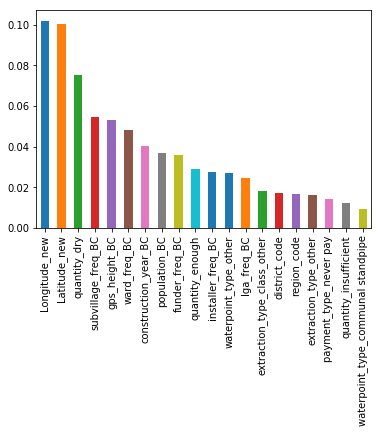

In [123]:
features = RF_model.feature_importances_
imp_features = np.argsort(features)[::-1]
k = 20
print(training_data.columns[imp_features[:10]])
series_imp_features = pd.Series(features[imp_features[:k]], training_data.columns[imp_features[:k]])
series_imp_features.plot(kind='bar')

In [119]:
# Using a different Classifier
GB_model = GradientBoostingClassifier(n_estimators=100)
GB_model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [120]:
#Predict validation data
y_pred = GB_model.predict(X_valid)
acc = accuracy_score(y_valid, y_pred)
fscore = fbeta_score(y_valid, y_pred, average='weighted', beta=0.5)
print('GB Accuracy:', acc)
print('GB Fbeta score:', fscore)

GB Accuracy: 0.755303030303
GB Fbeta score: 0.736586162659


Index(['Longitude_new', 'Latitude_new', 'lga_freq_BC', 'quantity_dry',
       'construction_year_BC', 'funder_freq_BC', 'installer_freq_BC',
       'district_code', 'region_code', 'gps_height_BC'],
      dtype='object')


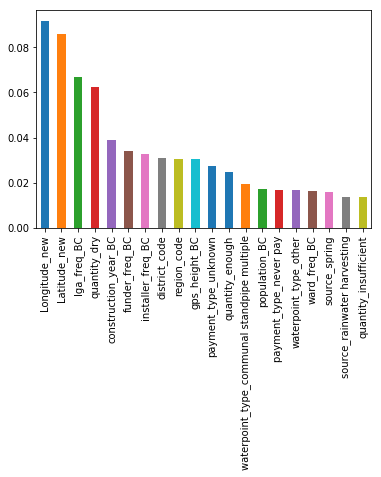

In [124]:
features = GB_model.feature_importances_
imp_features = np.argsort(features)[::-1]
k = 20
print(training_data.columns[imp_features[:10]])
series_imp_features = pd.Series(features[imp_features[:k]], training_data.columns[imp_features[:k]])
series_imp_features.plot(kind='bar')

In [125]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [145]:
# Making Grid search for adjusting the boosting params of GBM Model to find n_estimators, given a high value of learning rate
# This is important to make the fitting faster for the tuning of tree based parameters. 
clf = GradientBoostingClassifier(learning_rate=1.75,
                                 #n_estimators=100,
                                min_samples_split=500,
                                min_samples_leaf=50,
                                max_depth=8,
                                max_features='sqrt',
                                subsample=0.8)
param_dist = {"n_estimators": [20, 40, 60, 80]}
             #"max_depth":[3, 5, 7],
             #"criterion": ["gini", "entropy"]}
Shuffle_cv = StratifiedShuffleSplit(test_size=0.2, random_state=42)
#scorer = make_scorer(accuracy_score)
scorer = make_scorer(fbeta_score, average='weighted', beta=0.5)
gridCV = GridSearchCV(clf, param_dist, scoring=scorer, cv=Shuffle_cv)

In [146]:
from time import time
start = time()
grid_fit = gridCV.fit(X_train, y_train)
print("GridSearchCV took %.2f seconds for 4 candidates"
      " parameter settings." % ((time() - start)))
report(grid_fit.cv_results_)
best_clf = grid_fit.best_estimator_

GridSearchCV took 540.08 seconds for 4 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.759 (std: 0.005)
Parameters: {'n_estimators': 60}

Model with rank: 2
Mean validation score: 0.759 (std: 0.004)
Parameters: {'n_estimators': 40}

Model with rank: 3
Mean validation score: 0.755 (std: 0.004)
Parameters: {'n_estimators': 20}



In [147]:
# introducing randomized search CV for other tuning other tree parameters of GradientBoosting Classifier
# from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint, uniform as sp_uniform
clf = GradientBoostingClassifier(n_estimators=60, 
                                 learning_rate=1.75, 
                                 max_features='sqrt', 
                                 subsample=0.8, 
                                 random_state=10)
# specify parameters and distributions to sample from
#C = sp_uniform(loc=0.6, scale=0.4)
parameters2 = {'max_depth':sp_randint(5,17),
              'min_samples_split':sp_randint(100, 600),
              #'min_samples_leaf':sp_randint(20, 80),
              #'max_features':['sqrt', 'log2', None],
              #'subsample':C}
              }

In [148]:
# run randomized search
n_iter_search = 30
Shuffle_cv = StratifiedShuffleSplit(test_size=0.2, random_state=42)
scorer = make_scorer(fbeta_score, average='weighted', beta=0.5)
random_search = RandomizedSearchCV(clf, parameters2,
                                   n_iter=n_iter_search, 
                                   cv= Shuffle_cv, 
                                   scoring=scorer, 
                                   verbose=n_iter_search)

In [149]:
from time import time
start = time()
random_search.fit(x, labels)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV] max_depth=5, min_samples_split=381 ..............................
[CV]  max_depth=5, min_samples_split=381, score=0.7584073593605859, total=  10.6s
[CV] max_depth=5, min_samples_split=381 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.1s remaining:    0.0s


[CV]  max_depth=5, min_samples_split=381, score=0.7523969684450056, total=   9.9s
[CV] max_depth=5, min_samples_split=381 ..............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.6s remaining:    0.0s


[CV]  max_depth=5, min_samples_split=381, score=0.7514190242694028, total=  10.4s
[CV] max_depth=5, min_samples_split=381 ..............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.6s remaining:    0.0s


[CV]  max_depth=5, min_samples_split=381, score=0.7587157581390216, total=  10.5s
[CV] max_depth=5, min_samples_split=381 ..............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   43.8s remaining:    0.0s


[CV]  max_depth=5, min_samples_split=381, score=0.756400387456304, total=  10.8s
[CV] max_depth=5, min_samples_split=381 ..............................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   55.2s remaining:    0.0s


[CV]  max_depth=5, min_samples_split=381, score=0.7583407335202662, total=  12.1s
[CV] max_depth=5, min_samples_split=381 ..............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.1min remaining:    0.0s


[CV]  max_depth=5, min_samples_split=381, score=0.7593100806832483, total=  11.8s
[CV] max_depth=5, min_samples_split=381 ..............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.3min remaining:    0.0s


[CV]  max_depth=5, min_samples_split=381, score=0.7491813370288396, total=  11.5s
[CV] max_depth=5, min_samples_split=381 ..............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.5min remaining:    0.0s


[CV]  max_depth=5, min_samples_split=381, score=0.7573694660807142, total=  11.6s
[CV] max_depth=5, min_samples_split=381 ..............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.7min remaining:    0.0s


[CV]  max_depth=5, min_samples_split=381, score=0.7549905200192336, total=  11.6s
[CV] max_depth=7, min_samples_split=129 ..............................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.0min remaining:    0.0s


[CV]  max_depth=7, min_samples_split=129, score=0.7480794958544985, total=  15.8s
[CV] max_depth=7, min_samples_split=129 ..............................


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:  2.2min remaining:    0.0s


[CV]  max_depth=7, min_samples_split=129, score=0.7077370999021858, total=  16.1s
[CV] max_depth=7, min_samples_split=129 ..............................


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  2.5min remaining:    0.0s


[CV]  max_depth=7, min_samples_split=129, score=0.7466742949872209, total=  16.7s
[CV] max_depth=7, min_samples_split=129 ..............................


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:  2.8min remaining:    0.0s


[CV]  max_depth=7, min_samples_split=129, score=0.7488694074863467, total=  19.1s
[CV] max_depth=7, min_samples_split=129 ..............................


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:  3.1min remaining:    0.0s


[CV]  max_depth=7, min_samples_split=129, score=0.7439662884765478, total=  16.6s
[CV] max_depth=7, min_samples_split=129 ..............................


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  3.4min remaining:    0.0s


[CV]  max_depth=7, min_samples_split=129, score=0.7457903421465182, total=  17.6s
[CV] max_depth=7, min_samples_split=129 ..............................


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  3.7min remaining:    0.0s


[CV]  max_depth=7, min_samples_split=129, score=0.7466900723622527, total=  16.5s
[CV] max_depth=7, min_samples_split=129 ..............................


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:  4.0min remaining:    0.0s


[CV]  max_depth=7, min_samples_split=129, score=0.7514644133333915, total=  17.2s
[CV] max_depth=7, min_samples_split=129 ..............................


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  4.3min remaining:    0.0s


[CV]  max_depth=7, min_samples_split=129, score=0.7264020116493088, total=  17.2s
[CV] max_depth=7, min_samples_split=129 ..............................


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:  4.6min remaining:    0.0s


[CV]  max_depth=7, min_samples_split=129, score=0.7427028715385146, total=  16.0s
[CV] max_depth=9, min_samples_split=567 ..............................


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.9min remaining:    0.0s


[CV]  max_depth=9, min_samples_split=567, score=0.749828356438716, total=  18.9s
[CV] max_depth=9, min_samples_split=567 ..............................


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:  5.2min remaining:    0.0s


[CV]  max_depth=9, min_samples_split=567, score=0.7397847166550338, total=  19.6s
[CV] max_depth=9, min_samples_split=567 ..............................


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:  5.6min remaining:    0.0s


[CV]  max_depth=9, min_samples_split=567, score=0.7481538307565744, total=  21.5s
[CV] max_depth=9, min_samples_split=567 ..............................


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:  5.9min remaining:    0.0s


[CV]  max_depth=9, min_samples_split=567, score=0.7558679049230781, total=  20.4s
[CV] max_depth=9, min_samples_split=567 ..............................


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  6.3min remaining:    0.0s


[CV]  max_depth=9, min_samples_split=567, score=0.745736248896733, total=  20.6s
[CV] max_depth=9, min_samples_split=567 ..............................


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  6.6min remaining:    0.0s


[CV]  max_depth=9, min_samples_split=567, score=0.7513492436353778, total=  19.5s
[CV] max_depth=9, min_samples_split=567 ..............................


[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:  7.0min remaining:    0.0s


[CV]  max_depth=9, min_samples_split=567, score=0.7382441403277341, total=  21.0s
[CV] max_depth=9, min_samples_split=567 ..............................


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  7.3min remaining:    0.0s


[CV]  max_depth=9, min_samples_split=567, score=0.748476371349862, total=  20.7s
[CV] max_depth=9, min_samples_split=567 ..............................


[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:  7.7min remaining:    0.0s


[CV]  max_depth=9, min_samples_split=567, score=0.6990692925154707, total=  21.4s
[CV] max_depth=9, min_samples_split=567 ..............................


[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:  8.1min remaining:    0.0s


[CV]  max_depth=9, min_samples_split=567, score=0.7516446239324145, total=  21.1s
[CV] max_depth=7, min_samples_split=249 ..............................
[CV]  max_depth=7, min_samples_split=249, score=0.7135972230640621, total=  17.1s
[CV] max_depth=7, min_samples_split=249 ..............................
[CV]  max_depth=7, min_samples_split=249, score=0.7585494791779794, total=  16.3s
[CV] max_depth=7, min_samples_split=249 ..............................
[CV]  max_depth=7, min_samples_split=249, score=0.7307013964692324, total=  17.6s
[CV] max_depth=7, min_samples_split=249 ..............................
[CV]  max_depth=7, min_samples_split=249, score=0.7551874085786502, total=  16.3s
[CV] max_depth=7, min_samples_split=249 ..............................
[CV]  max_depth=7, min_samples_split=249, score=0.7284230829816258, total=  15.8s
[CV] max_depth=7, min_samples_split=249 ..............................
[CV]  max_depth=7, min_samples_split=249, score=0.7585936970816156, total=  16.6s


[CV]  max_depth=9, min_samples_split=503, score=0.7545363432833303, total=  20.7s
[CV] max_depth=9, min_samples_split=503 ..............................
[CV]  max_depth=9, min_samples_split=503, score=0.7477793744365703, total=  19.8s
[CV] max_depth=9, min_samples_split=503 ..............................
[CV]  max_depth=9, min_samples_split=503, score=0.760693013613601, total=  21.0s
[CV] max_depth=9, min_samples_split=503 ..............................
[CV]  max_depth=9, min_samples_split=503, score=0.7539983988197504, total=  21.0s
[CV] max_depth=9, min_samples_split=503 ..............................
[CV]  max_depth=9, min_samples_split=503, score=0.7605471707635147, total=  20.9s
[CV] max_depth=9, min_samples_split=503 ..............................
[CV]  max_depth=9, min_samples_split=503, score=0.7534039065632319, total=  20.6s
[CV] max_depth=9, min_samples_split=503 ..............................
[CV]  max_depth=9, min_samples_split=503, score=0.7536936638444909, total=  21.0s
[

[CV]  max_depth=9, min_samples_split=521, score=0.7322889567394454, total=  17.4s
[CV] max_depth=9, min_samples_split=521 ..............................
[CV]  max_depth=9, min_samples_split=521, score=0.7333453036154329, total=  17.0s
[CV] max_depth=9, min_samples_split=521 ..............................
[CV]  max_depth=9, min_samples_split=521, score=0.7209476085584559, total=  18.0s
[CV] max_depth=7, min_samples_split=558 ..............................
[CV]  max_depth=7, min_samples_split=558, score=0.762438273615312, total=  13.3s
[CV] max_depth=7, min_samples_split=558 ..............................
[CV]  max_depth=7, min_samples_split=558, score=0.7609021905603541, total=  16.0s
[CV] max_depth=7, min_samples_split=558 ..............................
[CV]  max_depth=7, min_samples_split=558, score=0.7552030971049569, total=  14.7s
[CV] max_depth=7, min_samples_split=558 ..............................
[CV]  max_depth=7, min_samples_split=558, score=0.7554315185121712, total=  14.5s
[

[CV]  max_depth=9, min_samples_split=597, score=0.7019589230326932, total=  17.4s
[CV] max_depth=9, min_samples_split=597 ..............................
[CV]  max_depth=9, min_samples_split=597, score=0.7533495786998431, total=  17.0s
[CV] max_depth=9, min_samples_split=597 ..............................
[CV]  max_depth=9, min_samples_split=597, score=0.7235313702438138, total=  16.8s
[CV] max_depth=9, min_samples_split=597 ..............................
[CV]  max_depth=9, min_samples_split=597, score=0.7221189919047266, total=  17.9s
[CV] max_depth=9, min_samples_split=597 ..............................
[CV]  max_depth=9, min_samples_split=597, score=0.7564700981163178, total=  16.5s
[CV] max_depth=9, min_samples_split=597 ..............................
[CV]  max_depth=9, min_samples_split=597, score=0.7555461262951834, total=  17.1s
[CV] max_depth=9, min_samples_split=597 ..............................
[CV]  max_depth=9, min_samples_split=597, score=0.7325909312400627, total=  16.6s


[CV]  max_depth=13, min_samples_split=353, score=0.556612099883219, total=  33.4s
[CV] max_depth=13, min_samples_split=353 .............................
[CV]  max_depth=13, min_samples_split=353, score=0.6375392884600535, total=  27.6s
[CV] max_depth=13, min_samples_split=353 .............................
[CV]  max_depth=13, min_samples_split=353, score=0.5463291528474248, total=  30.0s
[CV] max_depth=13, min_samples_split=353 .............................
[CV]  max_depth=13, min_samples_split=353, score=0.6610657486941839, total=  27.6s
[CV] max_depth=13, min_samples_split=353 .............................
[CV]  max_depth=13, min_samples_split=353, score=0.691204676759698, total=  28.1s
[CV] max_depth=9, min_samples_split=144 ..............................
[CV]  max_depth=9, min_samples_split=144, score=0.7435205230487901, total=  19.7s
[CV] max_depth=9, min_samples_split=144 ..............................
[CV]  max_depth=9, min_samples_split=144, score=0.672749904606106, total=  21.0

[CV]  max_depth=13, min_samples_split=306, score=0.5495537710840842, total=  38.7s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 116.9min finished


RandomizedSearchCV took 7032.00 seconds for 30 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.757 (std: 0.007)
Parameters: {'max_depth': 6, 'min_samples_split': 461}

Model with rank: 2
Mean validation score: 0.756 (std: 0.007)
Parameters: {'max_depth': 7, 'min_samples_split': 558}

Model with rank: 3
Mean validation score: 0.756 (std: 0.008)
Parameters: {'max_depth': 6, 'min_samples_split': 326}



In [150]:
# Now we fix max_depth = 6, min_samples_split= 461
# Tuning min_samples_leaf
clf = GradientBoostingClassifier(n_estimators=60, 
                                 learning_rate=1.75,
                                 max_depth=6,
                                 min_samples_split=461,
                                 max_features='sqrt')
# specify parameters and distributions to sample from
#C = sp_uniform(loc=0.8, scale=0.2)
parameters3 = {'min_samples_leaf':sp_randint(20, 70),
              #'max_features':['sqrt', 'log2', None],
              }
# run randomized search
n_iter_search = 20
Shuffle_cv = StratifiedShuffleSplit(test_size=0.2, random_state=42)
scorer = make_scorer(fbeta_score, average='weighted', beta=0.5)
random_search = RandomizedSearchCV(clf, parameters3,n_jobs=6,
                                   n_iter=n_iter_search, cv= Shuffle_cv, scoring=scorer, verbose=1)

In [151]:
from time import time
start = time()
random_search.fit(x, labels)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed: 30.6min
[Parallel(n_jobs=6)]: Done 200 out of 200 | elapsed: 32.0min finished


RandomizedSearchCV took 1939.34 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.772 (std: 0.003)
Parameters: {'min_samples_leaf': 49}

Model with rank: 2
Mean validation score: 0.771 (std: 0.004)
Parameters: {'min_samples_leaf': 68}

Model with rank: 3
Mean validation score: 0.771 (std: 0.006)
Parameters: {'min_samples_leaf': 46}



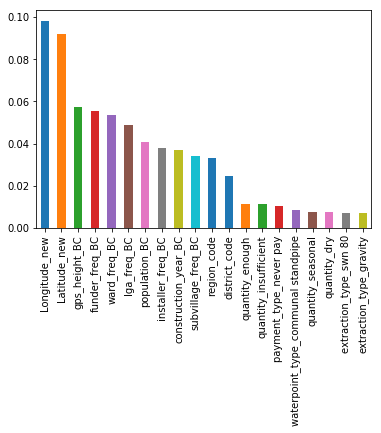

In [152]:
# Looking at top 20 feature importances - 
features = random_search.best_estimator_.feature_importances_
imp_features = np.argsort(features)[::-1]
k = 20
#print(training_data.columns[imp_features[:10]])
series_imp_features = pd.Series(features[imp_features[:k]], training_data.columns[imp_features[:k]])
series_imp_features.plot(kind='bar')

In [153]:
# Fixing min_samples_leaf = 49, we now look at max_features
clf = GradientBoostingClassifier(n_estimators=60, 
                                 learning_rate=1.75,
                                 max_depth=6,
                                 min_samples_split=461, 
                                 min_samples_leaf=49, 
                                 subsample=0.8)
# specify parameters and distributions to sample from
parameters4 = {'max_features': range(5, 41, 5)}

# run GridSearch
Shuffle_cv = StratifiedShuffleSplit(test_size=0.2, random_state=42)
scorer = make_scorer(fbeta_score, average='weighted', beta=0.5)
grid_search = GridSearchCV(clf, parameters4,
                           n_jobs=6, 
                           cv= Shuffle_cv, 
                           scoring=scorer, 
                           verbose=10)
start = time()
grid_fit = grid_search.fit(X_train, y_train)
print("GridSearchCV took %.2f seconds for 8 candidates"
      " parameter settings." % ((time() - start)))
report(grid_search.cv_results_)
best_clf = grid_search.best_estimator_

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   19.4s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   29.5s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done  78 out of  80 | elapsed: 10.9min remaining:   16.6s
[Parallel(n_jobs=6)]: Done  80 out of  80 | elapsed: 11.0min finished


GridSearchCV took 672.70 seconds for 8 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.760 (std: 0.004)
Parameters: {'max_features': 15}

Model with rank: 2
Mean validation score: 0.759 (std: 0.003)
Parameters: {'max_features': 20}

Model with rank: 3
Mean validation score: 0.758 (std: 0.008)
Parameters: {'max_features': 30}



In [155]:
# Fixing max_features = 15. Now tuning subsample.
# Fixing min_samples_leaf = 49, we now look at max_features
clf = GradientBoostingClassifier(n_estimators=60, 
                                 learning_rate=1.75,
                                 max_depth=6,
                                 min_samples_split=461, 
                                 min_samples_leaf=49, 
                                 max_features=15)
# specify parameters and distributions to sample from
parameters5 = {'subsample': [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]}

# run GridSearch
Shuffle_cv = StratifiedShuffleSplit(test_size=0.2, random_state=42)
scorer = make_scorer(fbeta_score, average='weighted', beta=0.5)
grid_search = GridSearchCV(clf, parameters5,
                           n_jobs=6, 
                           cv= Shuffle_cv, 
                           scoring=scorer, 
                           verbose=10)
start = time()
grid_fit = grid_search.fit(X_train, y_train)
print("GridSearchCV took %.2f seconds for 8 candidates"
      " parameter settings." % ((time() - start)))
report(grid_search.cv_results_)
best_clf = grid_search.best_estimator_

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   37.6s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   48.2s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  6.2min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  7.3min
[Parallel(n_jobs=6)]: Done  78 out of  80 | elapsed:  9.7min remaining:   14.8s
[Parallel(n_jobs=6)]: Done  80 out of  80 | elapsed: 10.0min finished


GridSearchCV took 615.60 seconds for 8 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.765 (std: 0.004)
Parameters: {'subsample': 0.9}

Model with rank: 2
Mean validation score: 0.764 (std: 0.002)
Parameters: {'subsample': 0.95}

Model with rank: 3
Mean validation score: 0.762 (std: 0.002)
Parameters: {'subsample': 0.85}



In [160]:
#tuning the learning_rate
clf_final = GradientBoostingClassifier(n_estimators=800, 
                                 learning_rate=0.1, 
                                 min_samples_split=461, 
                                 min_samples_leaf=49, 
                                 subsample=0.9, 
                                 max_depth=6, 
                                 max_features=15)
clf_final.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=15, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=49, min_samples_split=461,
              min_weight_fraction_leaf=0.0, n_estimators=800,
              presort='auto', random_state=None, subsample=0.9, verbose=0,
              warm_start=False)

In [161]:
#Predict validation data
y_pred = clf_final.predict(X_valid)
acc = accuracy_score(y_valid, y_pred)
fscore = fbeta_score(y_valid, y_pred, average='weighted', beta=0.5)
print('Optimized GB Accuracy:', acc)
print('Optimized GB Fbeta score:', fscore)

Optimized GB Accuracy: 0.802693602694
Optimized GB Fbeta score: 0.793573390682


In [166]:
# Getting the output
pred_y = clf_final.predict(testing_data)
cat_pred_y = LEncoder.inverse_transform(pred_y)
print(cat_pred_y[0])

functional


In [167]:
# output into a submission file
output_df = pd.DataFrame({'status_group':cat_pred_y}, index=test_features.id)
output_df.to_csv('submissionFile.csv')